# Setup

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics.pairwise

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import umap

In [2]:
def read_data(filename="all_letters.csv"):
    # Read preprocessed CSV file
    df = pd.read_csv(filename, sep="\t", header=None)
    df.columns = ["Nb", "Author", "Content"]
    return df

# Analysis 1: Do letters become "more similar" to each other over time?

In [11]:
def fit_model(df, n_gram_n = 1, min_word_length = 3, normalise_counts = False, binary = False):
    # We will fit a bag of words model with n-grams, consisting of l+ letters only
    
    # normalise_counts: Norm word counts across the letters?
    
    # binary: Binary presence-absence data instead of frequencies?
    # Apparently, this does not alter results qualitatively,
    # regardless of whether wie normalise word counts or not
    
    # Model fitting
    token_pattern = "[a-zA-Z]{" + str(min_word_length) + ",100000}"
    model = CountVectorizer(ngram_range=(n_gram_n,n_gram_n), token_pattern=token_pattern, binary=binary)
    X = model.fit_transform(df.Content)
    X = X.toarray()
    feature_names = model.get_feature_names()

    # Norming words if desired
    if normalise_counts:
        X = (X - X.mean(axis=0)) / X.std(axis=0)

    # Compute cosine similarity matrix on the individual letters (i.e. vectors)
    cosinesim = sklearn.metrics.pairwise.cosine_similarity(X)

    return feature_names, X, cosinesim


In [12]:
feature_names, X, cosinesim = fit_model(read_data())

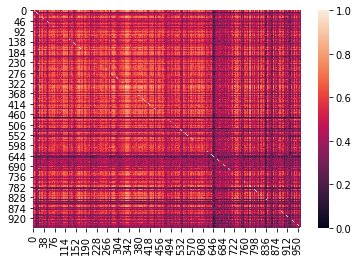

In [67]:
# Plot it
sns.heatmap(cosinesim)

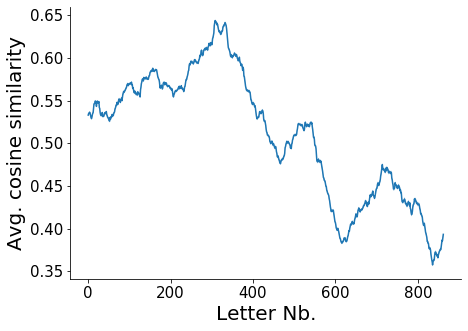

In [68]:
# We now slide a window of size 'window_size' over the 963 letters
# and compute the average pairwise cosine similarity 
window_size = 100

avg_similarities = []
se_similarities = []
nb_letter = range(0, len(cosinesim)-window_size)
for i in nb_letter:
    # Extract the similarity values from the triangular submatrix
    # from i to i+windowsize, excluding the 1s on diagonal
    submatrix = cosinesim[i:i+window_size,i:i+window_size]
    similarities = submatrix[np.triu_indices(window_size, k=1)]
    
    # Compute avg and sem
    avg_similarities.append(np.mean(similarities))
    se_similarities.append(sp.stats.sem(similarities))
avg_similarities = np.array(avg_similarities)
se_similarities = np.array(se_similarities)

# Generate plot and make visually more pleasing
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.set_xlabel("Letter Nb.", size=20)
ax.set_ylabel("Avg. cosine similarity", size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.plot(nb_letter, avg_similarities)
ax.fill_between(nb_letter, avg_similarities-se_similarities, avg_similarities+se_similarities, alpha=.5)

# Analysis 2: Embedding of letters

[0.54305117 0.02774717]


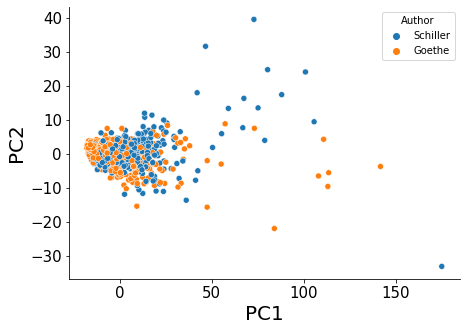

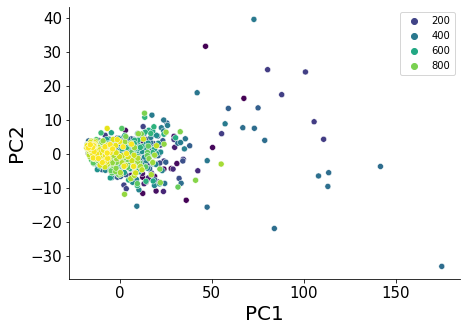

In [69]:
# First attempt: PCA
# Does not produce a clear picture, regardless of whether
# we normalise that word counts before or not

pca = PCA(n_components=2)
Y = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.scatterplot(x=Y[:,0], y=Y[:,1], ax=ax, hue=df.Author)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("PC1", size=20)
ax.set_ylabel("PC2", size=20)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.scatterplot(x=Y[:,0], y=Y[:,1], ax=ax, hue=[float(x) for x in df.Nb], palette="viridis")
ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("PC1", size=20)
ax.set_ylabel("PC2", size=20)
plt.show()

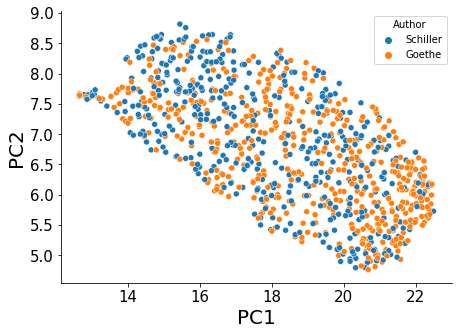

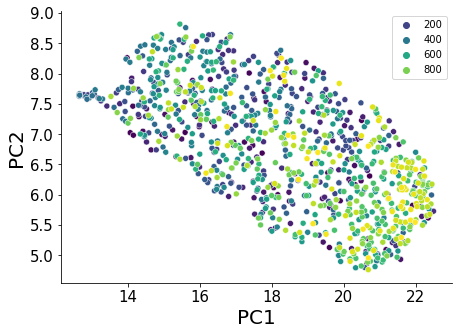

In [70]:
# Second attempt: umap
# Not a clear picture either, regardless of whether we
# normalise word counts or not

reducer = umap.UMAP()
Y = reducer.fit_transform(X)

fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.scatterplot(x=Y[:,0], y=Y[:,1], ax=ax, hue=df.Author)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("PC1", size=20)
ax.set_ylabel("PC2", size=20)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.scatterplot(x=Y[:,0], y=Y[:,1], ax=ax, hue=[float(x) for x in df.Nb], palette="viridis")
ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("PC1", size=20)
ax.set_ylabel("PC2", size=20)
plt.show()

# Analysis 3: Word frequencies over time

In [77]:
# We extract word frequency sum, avg, and stddev; and calculate C.V.
word_stats = pd.DataFrame([feature_names, X.sum(axis=0), X.mean(axis=0), X.std(axis=0)]).T
word_stats.columns = ["word", "sum-freq", "mean-freq", "std-freq"]
word_stats["cv-freq"] = word_stats["std-freq"] / word_stats["mean-freq"]

# We only retain words which have been mentioned at least 50 times and sort by C.V.
word_stats = word_stats.loc[word_stats["sum-freq"] > 50, :]
word_stats = word_stats.sort_values(by="cv-freq", ascending=False)

# Print some potentially interesting words
word_stats.head(50)

,word,sum-freq,mean-freq,std-freq,cv-freq
15384,trag,69,0.0716511,0.527594,7.36337
7720,handlung,52,0.0539979,0.385608,7.14117
6254,frankfurt,51,0.0529595,0.373442,7.05147
1863,bed,55,0.0571132,0.391841,6.86079
3209,charakter,65,0.0674974,0.423373,6.27243
10503,meister,62,0.0643821,0.384011,5.96456
5902,faust,55,0.0571132,0.331551,5.80516
12303,poesie,62,0.0643821,0.370244,5.75072
9898,leser,73,0.0758048,0.421965,5.56647
6685,gegenst,70,0.0726895,0.403659,5.55319


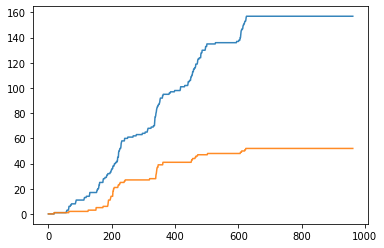

In [75]:
print_words = ["almanach", "almanachs"]
for print_word in print_words:
    freq_over_time = X[:, np.array(feature_names)==print_word]
    plt.plot(np.cumsum(freq_over_time), alpha=0.9)

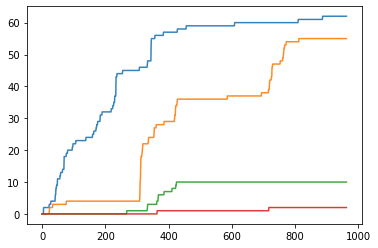

In [76]:
print_words = ["meister", "faust", "dorothea", "tasso"]
for print_word in print_words:
    freq_over_time = X[:, np.array(feature_names)==print_word]
    plt.plot(np.cumsum(freq_over_time), alpha=0.9)

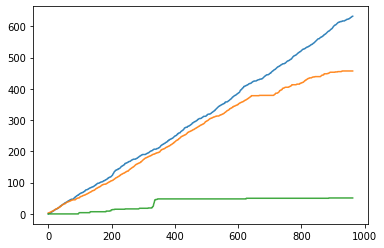

In [78]:
print_words = ["weimar", "jena", "frankfurt"]
for print_word in print_words:
    freq_over_time = X[:, np.array(feature_names)==print_word]
    plt.plot(np.cumsum(freq_over_time), alpha=0.9)

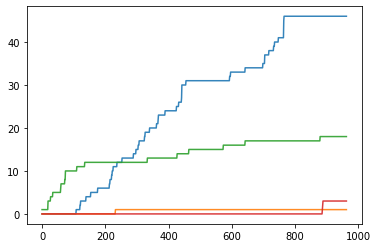

In [80]:
print_words = ["schlegel", "klopstock", "fichte", "hegel"]
for print_word in print_words:
    freq_over_time = X[:, np.array(feature_names)==print_word]
    plt.plot(np.cumsum(freq_over_time), alpha=0.9)